In [58]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import matplotlib.colors as colors
import pandas as pd
from scipy.stats import norm, chi2
from tqdm import tqdm
import gzip
import zlib


# NEW: we will use ks_2samp for a simple statistical test on Kd distributions
from scipy.stats import ks_2samp

# define matplotlib style
mpl.style.use("classic")
mpl.rc("xtick", labelsize=15)
mpl.rc("ytick", labelsize=15)
mpl.rc("xtick.major", size=14, width=2)
mpl.rc("xtick.minor", size=7, width=2, visible=True)
mpl.rc("ytick.major", size=14, width=2)
mpl.rc("ytick.minor", size=7, width=2, visible=True)
mpl.rc("lines", linewidth=2, markersize=5)
mpl.rc("axes", linewidth=2, labelsize=15, labelpad=2.5)
mpl.rc("legend", fontsize=15, loc="best", frameon=True, numpoints=1)

mpl.rc("font", family="STIXGeneral")
mpl.rc("mathtext", fontset="stix")

In [8]:
import pandas as pd

# --- I/O paths ----------------------------------------
INPUT_FILE = 'data/0.txt'
ALL_OUT   = 'all_events_with_toggle.csv'
COIN_OUT  = 'coincident_events_with_toggle.csv'

# --- Read the raw data via pandas -------------------
# Note: header=None tells pandas there is no header row,
#       comment='#' skips lines beginning with '#',
#       delim_whitespace=True splits on any whitespace.

df = pd.read_csv(
    INPUT_FILE,
    delim_whitespace=True,
    comment='#',
    header=None
)

print(df.head())

df.columns = ['EventNumber', 'Time', 'Date', 'TimeStamp_ms', 'ADC1', 'ADC2',
'SiPM_mV', 'Temp_C', 'Pressure_Pa', 'DeadTime_us', 'Coincident','ID']

# --- Compute the toggle bit --------------------------
df['toggle'] = df['TimeStamp_ms'] % 2

# ensure Date and Time are strings
df['Date'] = df['Date'].astype(str)
df['Time'] = df['Time'].astype(str)

# --- Build full datetime & sort ----------------------
# Assumes Date is M/D/YYYY and Time is H:M:S
df['DateTime'] = pd.to_datetime(
    df['Date'] + ' ' + df['Time'],
    format='%m/%d/%Y %H:%M:%S'
)
df.sort_values('DateTime', inplace=True)
df.reset_index(drop=True, inplace=True)

# --- Compute deltas and consistency check ------------
df['Δts_ms'] = df['TimeStamp_ms'].diff()
df['Δdt_ms'] = df['DateTime'].diff().dt.total_seconds() * 1000
df['ts_match'] = (df['Δts_ms'] - df['Δdt_ms']).abs() < 1.0  # ±1 ms tolerance

# --- Write out both full and coincident‐only CSVs ----
df.to_csv(ALL_OUT, index=False)
print(f"Wrote {len(df)} events to {ALL_OUT}")

df_coinc = df[df['Coincident'] == 1]
df_coinc.to_csv(COIN_OUT, index=False)
print(f"Wrote {len(df_coinc)} coincident events to {COIN_OUT}")

/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_68673/2311741596.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


   0        1         2    3      4      5      6     7          8      9   \
0   1  0:00:06  1/1/2019  275  572.0    8.0  13.51  25.8  102007.23  47973   
1   2  0:00:06  1/1/2019  357  241.0    8.0  10.13  25.8  102007.23   5964   
2   3  0:00:06  1/1/2019  362  955.0  251.0  50.36  25.8  102007.23   1847   
3   4  0:00:06  1/1/2019  440  644.0   10.0  14.75  25.8  102007.23   1850   
4   5  0:00:06  1/1/2019  601  964.0  372.0  69.78  25.8  102007.23  49821   

   10       11  
0   0  Umbriel  
1   0  Umbriel  
2   0  Umbriel  
3   0  Umbriel  
4   0  Umbriel  
Wrote 282464 events to all_events_with_toggle.csv
Wrote 210 coincident events to coincident_events_with_toggle.csv


In [31]:
#!/usr/bin/env python3
import os
import numpy as np
import pandas as pd
from scipy import stats

# --- 0) Map each .txt → its polarizer angle (°) ------------
file_to_angle = {
    'data/0.txt':   0,
    'data/10.txt':  10,
    'data/20.txt':  20,
    'data/40.txt':  40,
    'data/50.txt':  50,
    'data/60.txt':  60,
    'data/70.txt':  70,
    'data/80.txt':  80,
    'data/90.txt':  90,
}

# column names in each raw .txt
col_names = [
    'EventNumber', 'Time', 'Date', 'TimeStamp_ms',
    'ADC1', 'ADC2', 'SiPM_mV', 'Temp_C',
    'Pressure_Pa', 'DeadTime_us', 'Coincident', 'ID'
]

# will accumulate (toggle, angle) for Coincident==1
coin_frames = []

for fname, angle in file_to_angle.items():
    if not os.path.exists(fname):
        print(f"Warning: {fname} not found, skipping.")
        continue

    # --- 1) Read raw .txt into DataFrame ----------------
    df = pd.read_csv(
        fname,
        delim_whitespace=True,
        comment='#',
        header=None,
        names=col_names
    )

    # --- 2) Compute toggle bit ----------------------------
    df['toggle'] = (df['TimeStamp_ms'] % 2).astype(int)

    df = df[df['Coincident'] == 1]
    if df.empty:
        print(f"  -> No coincident events in {fname}.")
        continue

    # --- 3) Randomness battery on all events in this file ---
    bits = df['toggle'].values
    n = bits.size

    print(f"\n=== File: {os.path.basename(fname)} @ angle {angle}° ===")
    # Monobit
    ones = bits.sum()
    p_hat = ones / n
    z = (p_hat - 0.5) / np.sqrt(0.25 / n)
    p_val_freq = 2 * (1 - stats.norm.cdf(abs(z)))
    print(f"Monobit: 1s={ones}/{n}, p̂={p_hat:.4f}, p-value={p_val_freq:.3f}")

    # Runs
    runs = 1 + np.sum(bits[1:] != bits[:-1])
    mu_runs = 2*n*p_hat*(1-p_hat) + 1
    var_runs = (2*n*p_hat*(1-p_hat)*(2*n*p_hat*(1-p_hat)-n*p_hat*(1-p_hat))) \
               / (n**2*(n-1))
    z_runs = (runs - mu_runs) / np.sqrt(var_runs)
    p_val_runs = 2 * (1 - stats.norm.cdf(abs(z_runs)))
    print(f"Runs: runs={runs}, E[runs]={mu_runs:.1f}, p-value={p_val_runs:.3f}")

    # Serial (2-bit)
    if n % 2 != 0:
        bits = bits[:-1]
    pairs = bits.reshape(-1, 2)
    pair_vals = pairs[:,0]*2 + pairs[:,1]
    counts = np.bincount(pair_vals, minlength=4)
    expected = len(pair_vals)/4
    chi2_serial = ((counts-expected)**2/expected).sum()
    p_val_serial = 1 - stats.chi2.cdf(chi2_serial, df=3)
    print(f"Serial: counts={counts.tolist()}, p-value={p_val_serial:.3f}")

    # Serial (4-bit)
    if len(bits) % 4 != 0:
        bits = bits[:-(len(bits) % 4)]
    
    quads = bits.reshape(-1, 4)
    weights   = np.array([8, 4, 2, 1])
    quad_vals = quads.dot(weights)
    counts4   = np.bincount(quad_vals, minlength=16)
    expected4 = len(quad_vals) / 16
    chi2_4bit = ((counts4 - expected4)**2 / expected4).sum()
    p_val_4bit = 1 - stats.chi2.cdf(chi2_4bit, df=15)
    print(f"Serial 4-bit: counts={counts4.tolist()}, p-value={p_val_4bit:.3f}")

    # Lag-1 autocorrelation
    autocorr1 = np.corrcoef(bits[:-1], bits[1:])[0,1]
    print(f"Lag-1 autocorr: {autocorr1:.4f}")

    # Byte χ²
    m = (n//8)*8
    bytes_arr = np.packbits(bits[:m].reshape(-1,8), axis=1).flatten()
    freqs = np.bincount(bytes_arr, minlength=256)
    chi2_bytes = ((freqs - m/256)**2/(m/256)).sum()
    p_val_bytes = 1 - stats.chi2.cdf(chi2_bytes, df=255)
    print(f"Byte χ²: p-value={p_val_bytes:.3f}")

    # --- 4) Collect coincident toggles + angle -------------
    df_coinc = df[df['Coincident'] == 1]
    if df_coinc.empty:
        print("  -> No coincident events in this file.")
    else:
        coin_frames.append(
            pd.DataFrame({
                'toggle': df_coinc['toggle'].astype(int).values,
                'angle': angle
            })
        )

# --- 5) Angle vs toggle across all files ------------------
if not coin_frames:
    raise RuntimeError("No coincident events found in any file!")

coin_df = pd.concat(coin_frames, ignore_index=True)
angles  = coin_df['angle'].values
toggles = coin_df['toggle'].values
N_coin  = len(toggles)

print("\n=== Angle vs Toggle Independence Tests ===")

# Point-biserial correlation
r_pb, p_pb = stats.pointbiserialr(toggles, angles)
print(f"Point-biserial corr: r={r_pb:.4f}, p-value={p_pb:.3f}")

# χ² test of independence (12×2 contingency with 30° bins)
bins = np.linspace(0, 360, 13)  # 12 bins of 30°
angle_bin = pd.cut(angles, bins, include_lowest=True)
cont = pd.crosstab(angle_bin, toggles)
chi2_ind, p_ind, dof, exp = stats.chi2_contingency(cont)
print(f"Chi-sq indep: χ²={chi2_ind:.1f}, p-value={p_ind:.3f}, dof={dof}\n")
print("Contingency table (angle_bin × toggle):")
print(cont)

/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_69098/1902725769.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(



=== File: 0.txt @ angle 0° ===
Monobit: 1s=96/210, p̂=0.4571, p-value=0.214
Runs: runs=118, E[runs]=105.2, p-value=0.000
Serial: counts=[26, 30, 32, 17], p-value=0.168
Serial 4-bit: counts=[5, 0, 4, 1, 2, 7, 6, 2, 4, 3, 6, 3, 4, 3, 0, 2], p-value=0.172
Lag-1 autocorr: -0.1372
Byte χ²: p-value=0.995


/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_69098/1902725769.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(



=== File: 10.txt @ angle 10° ===
Monobit: 1s=351/648, p̂=0.5417, p-value=0.034
Runs: runs=312, E[runs]=322.8, p-value=0.000
Serial: counts=[71, 80, 75, 98], p-value=0.154
Serial 4-bit: counts=[4, 7, 9, 8, 4, 9, 11, 8, 13, 16, 7, 8, 22, 16, 4, 16], p-value=0.001
Lag-1 autocorr: 0.0319
Byte χ²: p-value=0.000


/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_69098/1902725769.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(



=== File: 20.txt @ angle 20° ===
Monobit: 1s=125/218, p̂=0.5734, p-value=0.030
Runs: runs=121, E[runs]=107.7, p-value=0.000
Serial: counts=[18, 33, 24, 34], p-value=0.093
Serial 4-bit: counts=[1, 1, 1, 7, 3, 4, 4, 8, 2, 3, 4, 5, 2, 6, 1, 2], p-value=0.112
Lag-1 autocorr: -0.1289
Byte χ²: p-value=0.997


/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_69098/1902725769.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(



=== File: 40.txt @ angle 40° ===
Monobit: 1s=210/396, p̂=0.5303, p-value=0.228
Runs: runs=201, E[runs]=198.3, p-value=0.000
Serial: counts=[43, 52, 48, 55], p-value=0.651
Serial 4-bit: counts=[6, 4, 5, 3, 10, 5, 6, 8, 3, 7, 6, 9, 6, 7, 6, 8], p-value=0.853
Lag-1 autocorr: -0.0167
Byte χ²: p-value=0.001


/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_69098/1902725769.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(



=== File: 50.txt @ angle 50° ===
Monobit: 1s=176/367, p̂=0.4796, p-value=0.434
Runs: runs=199, E[runs]=184.2, p-value=0.000
Serial: counts=[43, 63, 42, 35], p-value=0.023
Serial 4-bit: counts=[6, 4, 6, 4, 9, 12, 10, 7, 1, 5, 6, 5, 7, 4, 3, 2], p-value=0.106
Lag-1 autocorr: -0.0939
Byte χ²: p-value=0.011


/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_69098/1902725769.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(



=== File: 60.txt @ angle 60° ===
Monobit: 1s=278/512, p̂=0.5430, p-value=0.052
Runs: runs=251, E[runs]=255.1, p-value=0.000
Serial: counts=[52, 47, 83, 74], p-value=0.003
Serial 4-bit: counts=[6, 4, 8, 4, 4, 2, 12, 5, 14, 7, 10, 8, 6, 11, 14, 13], p-value=0.019
Lag-1 autocorr: 0.0139
Byte χ²: p-value=0.000


/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_69098/1902725769.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(



=== File: 70.txt @ angle 70° ===
Monobit: 1s=426/860, p̂=0.4953, p-value=0.785
Runs: runs=443, E[runs]=431.0, p-value=0.000
Serial: counts=[104, 122, 104, 100], p-value=0.439
Serial 4-bit: counts=[11, 14, 12, 9, 16, 20, 10, 10, 15, 19, 13, 11, 16, 13, 11, 15], p-value=0.709
Lag-1 autocorr: -0.0292
Byte χ²: p-value=0.000


/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_69098/1902725769.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(



=== File: 80.txt @ angle 80° ===
Monobit: 1s=245/541, p̂=0.4529, p-value=0.028
Runs: runs=277, E[runs]=269.1, p-value=0.000
Serial: counts=[74, 76, 71, 49], p-value=0.074
Serial 4-bit: counts=[13, 12, 7, 7, 9, 11, 10, 6, 9, 9, 8, 10, 4, 8, 10, 2], p-value=0.509
Lag-1 autocorr: -0.0293
Byte χ²: p-value=0.000


/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_69098/1902725769.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(



=== File: 90.txt @ angle 90° ===
Monobit: 1s=329/631, p̂=0.5214, p-value=0.282
Runs: runs=303, E[runs]=315.9, p-value=0.000
Serial: counts=[76, 80, 69, 90], p-value=0.403
Serial 4-bit: counts=[7, 14, 9, 8, 7, 13, 9, 10, 9, 10, 8, 11, 15, 4, 5, 18], p-value=0.142
Lag-1 autocorr: 0.0413
Byte χ²: p-value=0.000

=== Angle vs Toggle Independence Tests ===
Point-biserial corr: r=-0.0236, p-value=0.118
Chi-sq indep: χ²=5.2, p-value=0.074, dof=2

Contingency table (angle_bin × toggle):
col_0              0     1
row_0                     
(-0.001, 30.0]   504   572
(30.0, 60.0]     611   664
(60.0, 90.0]    1032  1000


/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_69098/3290147412.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_69098/3290147412.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_69098/3290147412.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_69098/3290147412.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_69098/3290147412.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_69098/3290147412.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_69098/3290147412.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/1r/x7pm

All plots saved as PNGs.


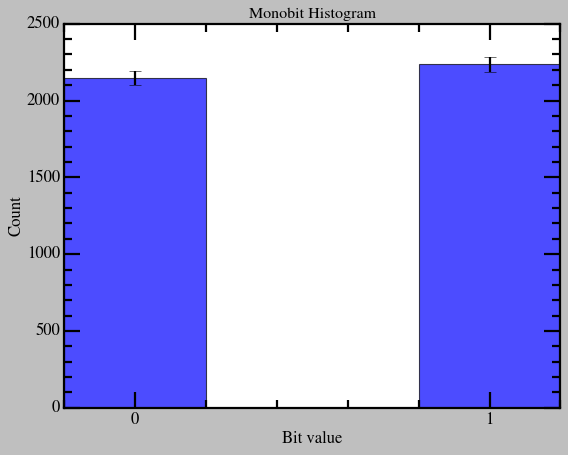

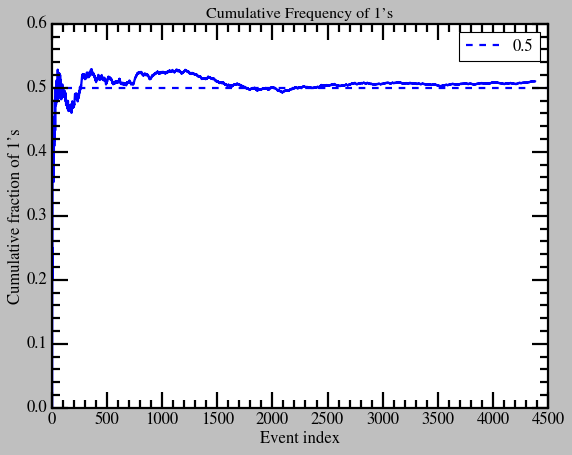

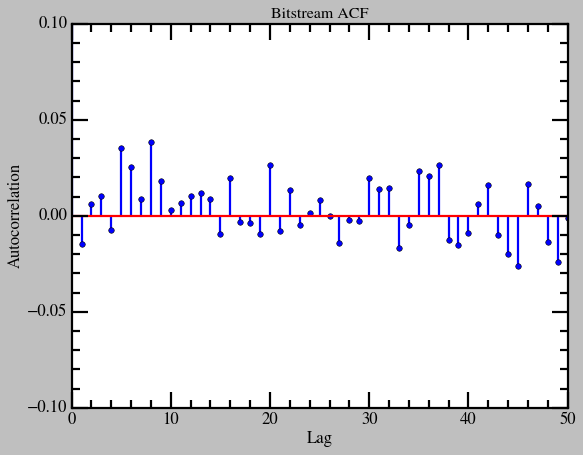

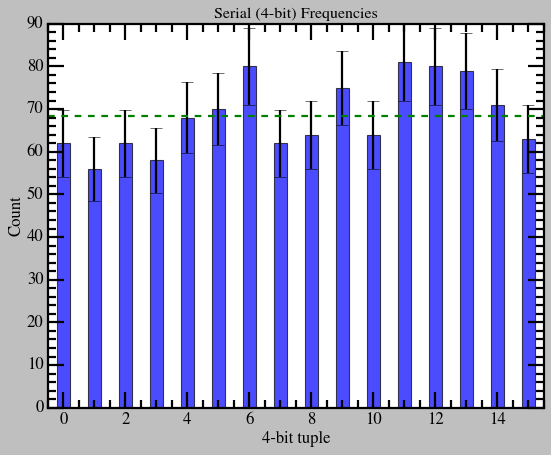

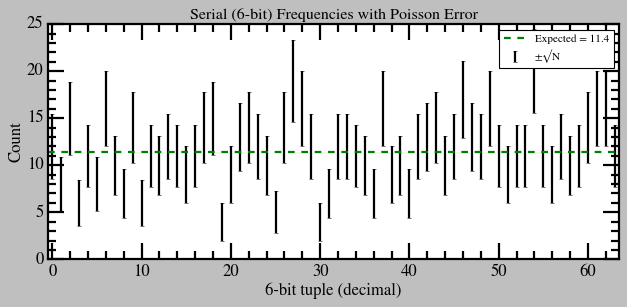

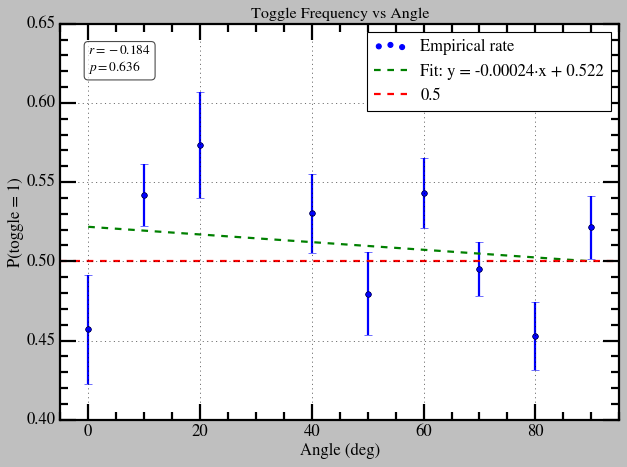

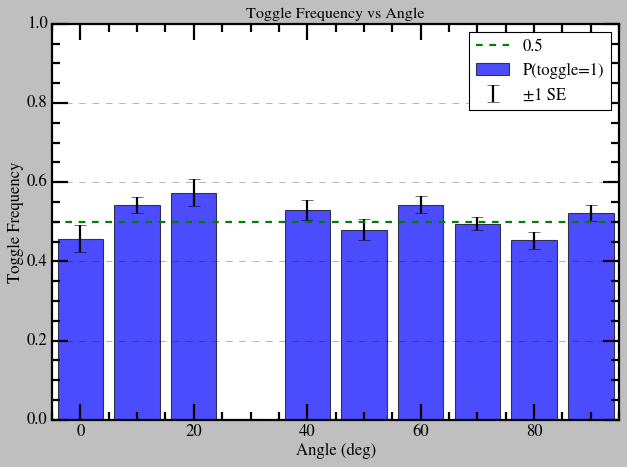

In [ ]:
#!/usr/bin/env python3

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
import scipy.stats as stats

# ─── 0) File → angle mapping & column names ──────────────────────────────
file_to_angle = {
    'data/0.txt':   0,
    'data/10.txt':  10,
    'data/20.txt':  20,
    'data/30.txt': 30,
    'data/40.txt':  40,
    'data/50.txt':  50,
    'data/60.txt': 60,
    'data/70.txt':  70,
    'data/80.txt':  80,
    'data/90.txt': 90,
    # …etc.
}

col_names = [
    'EventNumber', 'Time', 'Date', 'TimeStamp_ms',
    'ADC1', 'ADC2', 'SiPM_mV', 'Temp_C',
    'Pressure_Pa', 'DeadTime_us', 'Coincident','ID'
]

# ─── 1) Read all .txt, compute toggles & Δts ─────────────────────────────
frames = []
for fn, angle in file_to_angle.items():
    if not os.path.exists(fn):
        print(f"Warning: {fn} not found – skipping.")
        continue

    df = pd.read_csv(
        fn,
        delim_whitespace=True,
        comment='#',
        header=None,
        names=col_names
    )
    df['toggle'] = (df['TimeStamp_ms'] % 2).astype(int)
    df['angle']  = angle
    df = df[df['Coincident'] == 1]
    if df.empty:
        print(f"  -> No coincident events in {fn}.")
        continue
    frames.append(df)

if not frames:
    raise RuntimeError("No input files loaded!")

all_df = pd.concat(frames, ignore_index=True)

# sort by real time to get Δts correctly
all_df = all_df.sort_values(['Date','Time']).reset_index(drop=True)
all_df['Δts_ms'] = all_df['TimeStamp_ms'].diff()


# extract the series we’ll plot
bits    = all_df['toggle'].values
dt      = all_df['Δts_ms'].dropna().values
angles  = all_df['angle'].values

# ─── 2) Monobit Histogram ────────────────────────────────────────────────
plt.figure()
counts = [np.sum(bits==0), np.sum(bits==1)]
plt.bar([0,1], counts, width=0.4, alpha =0.7)
plt.errorbar(
    [0,1], counts,
    yerr=np.sqrt(counts),
    fmt='none', ecolor='k', capsize=5,
)
plt.xticks([0,1])
plt.xlabel('Bit value')
plt.ylabel('Count')
plt.title('Monobit Histogram')
plt.savefig('plot_monobit_histogram.png', dpi=300)



# ─── 3) Running Frequency over Time ─────────────────────────────────────
plt.figure()
cum_frac = np.cumsum(bits) / np.arange(1, len(bits)+1)
plt.plot(cum_frac)
plt.axhline(0.5, linestyle='--', label='0.5')
plt.xlabel('Event index')
plt.ylabel('Cumulative fraction of 1’s')
plt.title('Cumulative Frequency of 1’s')
plt.legend()
plt.savefig('plot_running_frequency.png', dpi=300)


# ─── 4) Autocorrelation Function ────────────────────────────────────────
plt.figure()
ac = acf(bits, nlags=50, fft=True)
plt.stem(range(len(ac)), ac)
plt.ylim(-0.1, 0.1)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Bitstream ACF')
plt.savefig('plot_autocorrelation.png', dpi=300)


# ─── 6) Serial 4-Bit Frequencies ────────────────────────────────────────
even_n = (len(bits) // 4) * 4
quads = bits[:even_n].reshape(-1, 4)
weights = np.array([8, 4, 2, 1])
quad_vals = quads.dot(weights)
# labels_4bit = [f"{i:04b}" for i in range(16)]
counts4 = np.bincount(quad_vals, minlength=16)
labels_4bit = np.linspace(0, 15, 16).astype(int)

plt.figure()
plt.bar(labels_4bit, counts4, width=0.4, alpha=0.7)
plt.errorbar(
    labels_4bit, counts4,
    yerr=np.sqrt(counts4),
    fmt='none', ecolor='k', capsize=5
)
plt.axhline(counts4.mean(), linestyle='--', color='C1', label='Expected')
plt.xlim(-0.5, 15.5)
plt.xlabel('4-bit tuple')
plt.ylabel('Count')
plt.title('Serial (4-bit) Frequencies')
plt.savefig('plot_serial_4bit_frequencies.png', dpi=300)

# ─── Serial (6-bit) Frequencies with Poisson Error ─────────────────────────

# trim so length is a multiple of 6
even_n = (len(bits) // 6) * 6
sextets = bits[:even_n].reshape(-1, 6)

# compute integer value of each 6-bit tuple: b0*32 + b1*16 + … + b5*1
weights6   = np.array([32, 16, 8, 4, 2, 1])
sextet_vals = sextets.dot(weights6)

# count occurrences of each of the 64 patterns
counts6 = np.bincount(sextet_vals, minlength=64)
labels6 = np.arange(64)

# expected count under uniform distribution
expected6 = sextet_vals.size / 64

# Poisson errors: sqrt(N)
errors6 = np.sqrt(counts6)

plt.figure(figsize=(8, 4))
plt.errorbar(
    labels6, counts6,
    yerr=errors6,
    fmt='none',
    ecolor='k',
    capsize=2,
    label='±√N'
)
plt.axhline(expected6, linestyle='--', color='C1',
            label=f'Expected = {expected6:.1f}')
plt.xlim(-0.5, 63.5)
plt.xlabel('6-bit tuple (decimal)')
plt.ylabel('Count')
plt.title('Serial (6-bit) Frequencies with Poisson Error')
plt.legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.savefig('plot_serial_6bit_frequencies.png', dpi=300)



# ─── 8) Toggle-Rate vs Angle ────────────────────────────────────────────
# Compute P(toggle=1) at each unique angle
# Build grouped stats
angle_df     = pd.DataFrame({'angle': angles, 'toggle': bits})
grouped      = angle_df.groupby('angle')['toggle']
rate_by_ang  = grouped.mean()
count_by_ang = grouped.count()
se_by_ang    = np.sqrt(rate_by_ang * (1 - rate_by_ang) / count_by_ang)

# Prepare x,y arrays
x = rate_by_ang.index.values
y = rate_by_ang.values

# Pearson r, p-value
r, pval = stats.pearsonr(x, y)

# Linear fit
slope, intercept = np.polyfit(x, y, 1)
y_fit = slope * x + intercept

# scatter
plt.figure()
plt.scatter(x, y, color='C0', label='Empirical rate')
# error bars
plt.errorbar(
    x, y, yerr=se_by_ang.values,
    fmt='o', color='C0', capsize=4
)
# fit line
plt.plot(x, y_fit, color='C1', linestyle='--',
         label=f'Fit: y = {slope:.5f}·x + {intercept:.3f}')
# annotate
txt = f"$r = {r:.3f}$\n$p = {pval:.3f}$"
plt.gca().text(
    0.05, 0.95, txt,
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)
plt.axhline(0.5, linestyle='--', color='C2', label='0.5')

plt.xlim(-5,95)

plt.xlabel('Angle (deg)')
plt.ylabel('P(toggle = 1)')
plt.title('Toggle Frequency vs Angle')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('plot_toggle_rate_vs_angle.png', dpi=300)

# ─── 7) Toggle Counts by Angle ─────────────────────────────────────────────

angle_stats = all_df.groupby('angle')['toggle'].agg(['mean','count'])
angle_stats['se'] = np.sqrt(
    angle_stats['mean'] * (1 - angle_stats['mean']) /
    angle_stats['count']
)

angles = angle_stats.index.values
freqs  = angle_stats['mean'].values
ses    = angle_stats['se'].values

plt.figure()
plt.bar(angles, freqs, width=8, alpha=0.7, label='P(toggle=1)')
plt.errorbar(
    angles, freqs, yerr=ses,
    fmt='none', ecolor='k', capsize=5,
    label='±1 SE'
)
plt.axhline(0.5, linestyle='--', color='C1', label='0.5')

plt.xlabel('Angle (deg)')
plt.ylabel('Toggle Frequency')
plt.title('Toggle Frequency vs Angle')
plt.ylim(0, 1)
plt.xlim(-5, 95)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('plot_toggle_frequency_by_angle.png', dpi=300)


print("All plots saved as PNGs.")

# Single line, space-separated
with open('all_events_bits.txt', 'w') as f:
    f.write(str(bits.tolist()).replace(",","").replace("[","").replace("]","").replace(" ",""))

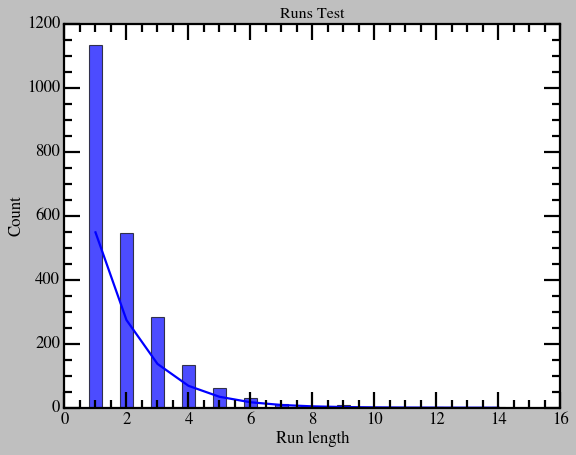

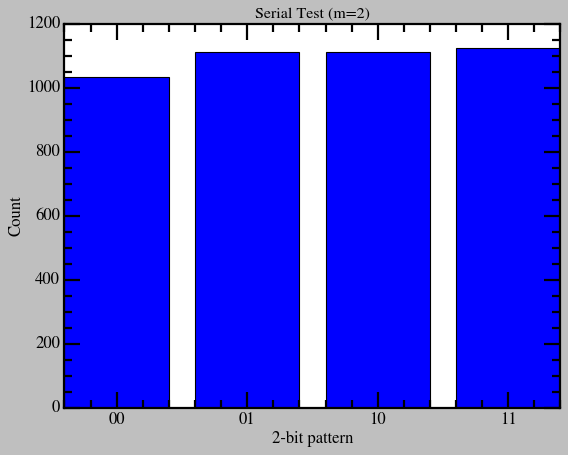

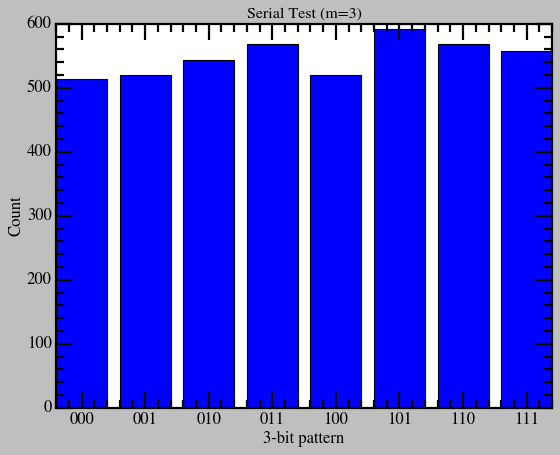

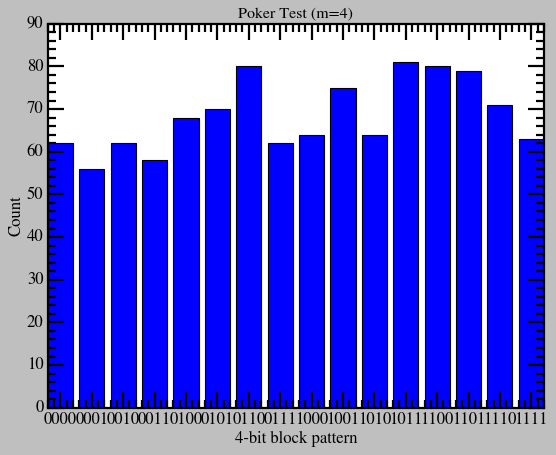

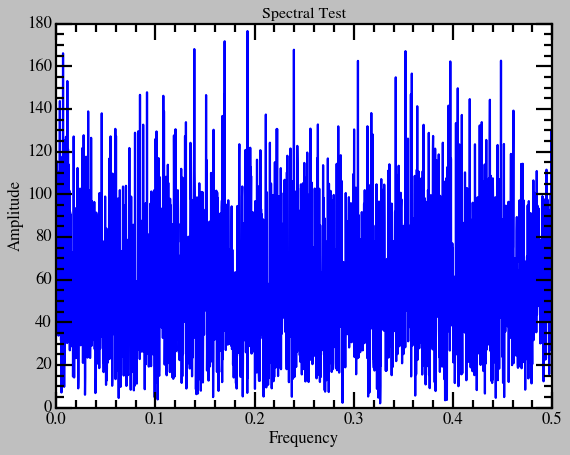

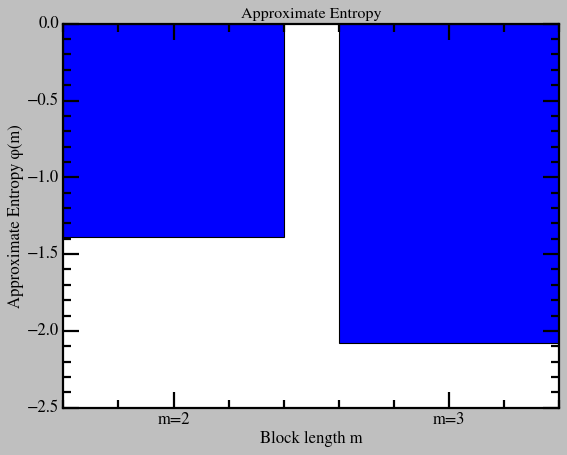

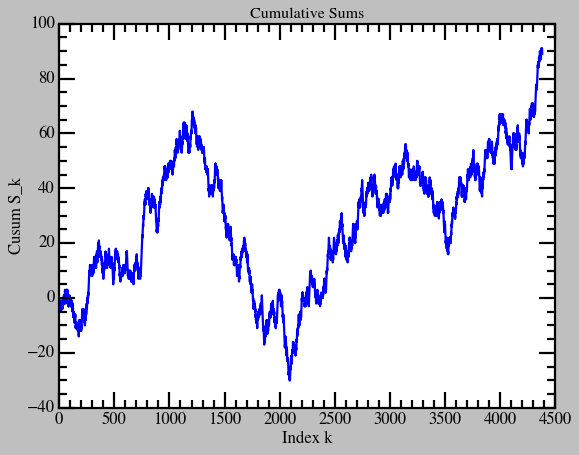

Original size (bytes): 547
Raw DEFLATE size (bytes): 552
Compression ratio: 1.009
Original size (bytes): 547
Gzip compressed size (bytes): 570
Compression ratio: 1.042
Lempel–Ziv complexity: 585
Lempel–Ziv complexity ratio: 1.119


In [63]:
# Read bits from file
with open('all_events_bits.txt', 'r') as f:
    bits = np.array(list(map(int, f.read().strip())), dtype=int)
N = len(bits)

# 3. Runs Test
runs = []
current = bits[0]
count = 1
for bit in bits[1:]:
    if bit == current:
        count += 1
    else:
        runs.append(count)
        current = bit
        count = 1
runs.append(count)

max_run = max(runs)
counts_run, bins = np.histogram(runs, bins=np.arange(1, max_run+2)-0.5)
expected_runs = [(N - k + 3)/(2**(k+2)) for k in range(1, max_run+1)]

plt.figure()
plt.bar(np.arange(1, max_run+1), counts_run, width=0.4, alpha=0.7)
plt.plot(np.arange(1, max_run+1), expected_runs)
plt.xlabel('Run length')
plt.ylabel('Count')
plt.title('Runs Test')

# 4. Serial Test for m=2 and m=3
for m in [2, 3]:
    patterns = {format(i, f'0{m}b'): 0 for i in range(2**m)}
    for i in range(N-m+1):
        pat = ''.join(bits[i:i+m].astype(str))
        patterns[pat] += 1

    plt.figure()
    plt.bar(list(patterns.keys()), list(patterns.values()))
    plt.xlabel(f'{m}-bit pattern')
    plt.ylabel('Count')
    plt.title(f'Serial Test (m={m})')

# 5. Poker Test (m=4)
m = 4
counts_poker = {format(i, '04b'): 0 for i in range(16)}
for i in range(0, N - N % m, m):
    block = bits[i:i+m]
    pat = ''.join(block.astype(str))
    counts_poker[pat] += 1

plt.figure()
plt.bar(list(counts_poker.keys()), list(counts_poker.values()))
plt.xlabel('4-bit block pattern')
plt.ylabel('Count')
plt.title('Poker Test (m=4)')

# 6. Spectral Test
vals = 2*bits - 1
spectrum = np.abs(np.fft.fft(vals))
freqs = np.fft.fftfreq(N)

plt.figure()
plt.plot(freqs[:N//2], spectrum[:N//2])
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Spectral Test')

# 7. Approximate Entropy & Cumulative Sums
def approx_entropy(bits, m):
    N = len(bits)
    counts = {}
    for i in range(N - m + 1):
        seq = tuple(bits[i:i+m])
        counts[seq] = counts.get(seq, 0) + 1
    total = N - m + 1
    phi = sum((count/total) * np.log(count/total) for count in counts.values())
    return phi

ae2 = approx_entropy(bits, 2)
ae3 = approx_entropy(bits, 3)

plt.figure()
plt.bar(['m=2', 'm=3'], [ae2, ae3])
plt.xlabel('Block length m')
plt.ylabel('Approximate Entropy φ(m)')
plt.title('Approximate Entropy')

cusum = np.cumsum(2*bits - 1)
plt.figure()
plt.plot(cusum)
plt.xlabel('Index k')
plt.ylabel('Cusum S_k')
plt.title('Cumulative Sums')

plt.show()

with open('all_events_bits.txt', 'r') as f:
    bit_str = f.read().strip()

# Pack bits into bytes
byte_vals = []
for i in range(0, len(bit_str) - (len(bit_str) % 8), 8):
    byte_vals.append(int(bit_str[i:i+8], 2))
data = bytes(byte_vals)

# Compute gzip compression
compressed = gzip.compress(data)
original_size = len(data)
compressed_size = len(compressed)
compression_ratio = compressed_size / original_size

# Raw DEFLATE (no headers/footers) using zlib with wbits=-15
compressor = zlib.compressobj(level=9, wbits=-15)
raw_deflate = compressor.compress(data) + compressor.flush()

original_size = len(data)
raw_deflate_size = len(raw_deflate)
raw_deflate_ratio = raw_deflate_size / original_size

print(f"Original size (bytes): {original_size}")
print(f"Raw DEFLATE size (bytes): {raw_deflate_size}")
print(f"Compression ratio: {raw_deflate_ratio:.3f}")

# Lempel–Ziv complexity (naive parsing)
def lz_complexity(s):
    n = len(s)
    i = 0
    dictionary = set()
    complexity = 0
    while i < n:
        length = 1
        # find the shortest substring not yet in dictionary
        while i + length <= n and s[i:i+length] in dictionary:
            length += 1
        # add new phrase (if within bounds)
        if i + length <= n:
            dictionary.add(s[i:i+length])
        complexity += 1
        i += length
    return complexity

lz_comp = lz_complexity(bit_str)
lz_comp_ratio = lz_comp / (len(bit_str)/np.log(len(bit_str)))

# Display results
print(f"Original size (bytes): {original_size}")
print(f"Gzip compressed size (bytes): {compressed_size}")
print(f"Compression ratio: {compression_ratio:.3f}")
print(f"Lempel–Ziv complexity: {lz_comp}")
print(f"Lempel–Ziv complexity ratio: {lz_comp_ratio:.3f}")